# Generate figures from DESEq2 analysis

## Load data and generate DE results

In [4]:
library(tidyverse)
library(DESeq2)
library(dendextend)
library(RColorBrewer)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  2.1.2     ✔ dplyr   0.8.1
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    com

In [2]:
curdir <- "/home/jovyan/work/scratch/analysis_output"
imgdir <- file.path(curdir, "img")

imgfile <- file.path(imgdir, "pilotdds2019.RData")

imgfile

attach(imgfile)

tools::md5sum(imgfile)

### List the objects that have been attached
ls(2)

ddsadd <- dds2019

detach(pos = 2)

[1] "/home/jovyan/work/scratch/analysis_output/img/pilotdds2019.RData"

/home/jovyan/work/scratch/analysis_output/img/pilotdds2019.RData 
                              "6632de5c8a2eed06d8c40c958e6f5d03"

[1] "dds2019"

In [5]:

### Estimate Size Factors
ddsadd <- estimateSizeFactors(ddsadd)
### Estimate Dispersion parameters (for each gene)
ddsadd <- estimateDispersions(ddsadd)
### Fit NB MLE model
ddsadd <- DESeq(ddsadd)

gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


## Dot Plots

In [10]:
### Merge gene expression with meta data
myDEplotData <- function(mydds, geneid, mergelab) {
    counts(mydds, normalize = TRUE) %>%
        as_tibble(rownames="gene") %>%
        filter(gene == geneid) %>%
        gather(Label, geneexp, -gene) %>%
        select(-gene) -> genedat

    colData(mydds) %>%
        as.data.frame %>%
        as_tibble %>%
        full_join(genedat, by = mergelab) -> genedat
    
    return(genedat)
}

### Plot using a single factor
myDEplot0 <- function(mydds, geneid, grpvar, mergelab) {
    mydat <- myDEplotData(mydds, geneid, mergelab)
    ggplot(mydat, aes_string(x=grpvar, y = "geneexp", col = grpvar))+ geom_point()
}


### Allow for coloring with respect to another factor
myDEplot <- function(mydds, geneid, grpvar, colvar, mergelab) {
    mydat <- myDEplotData(mydds, geneid, mergelab)
    ggplot(mydat, aes_string(x=grpvar, y = "geneexp", col = colvar))+ geom_point()
}


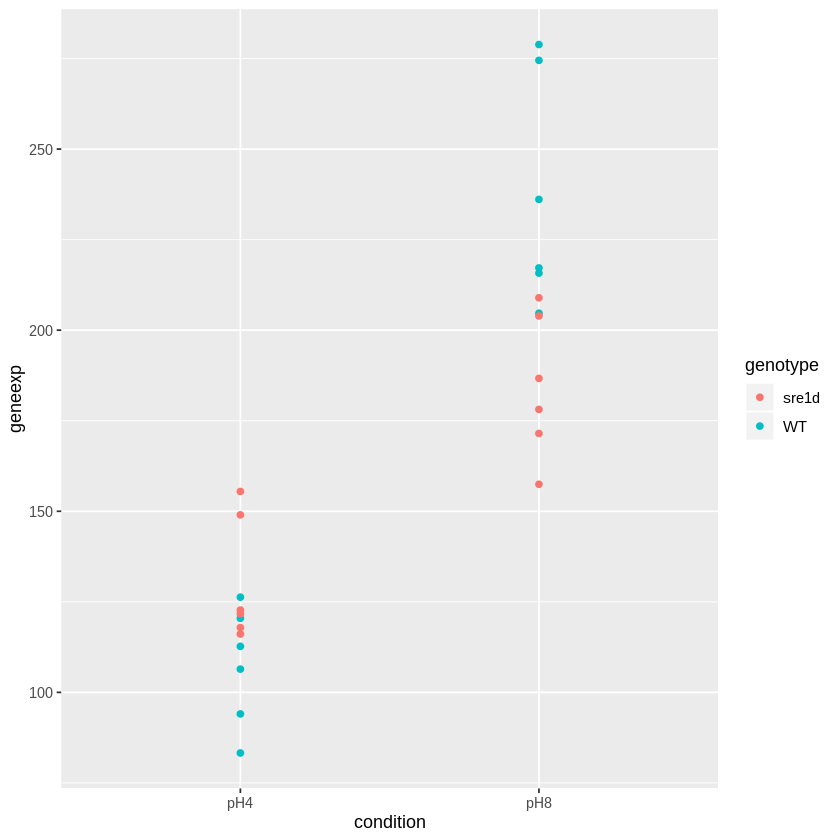

In [12]:
### Stratify by condition color by genotype
myDEplot(ddsadd, "CNAG_00003", "condition", "genotype", "Label")

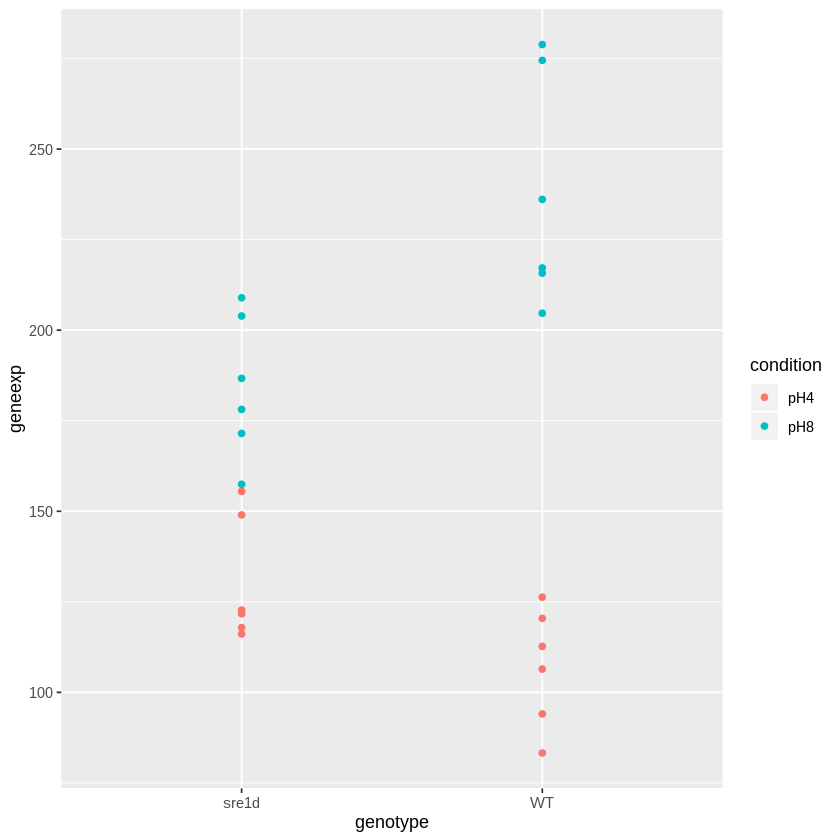

In [14]:
### Stratify by genotype color by conditon
myDEplot(ddsadd, "CNAG_00003", "genotype", "condition", "Label")

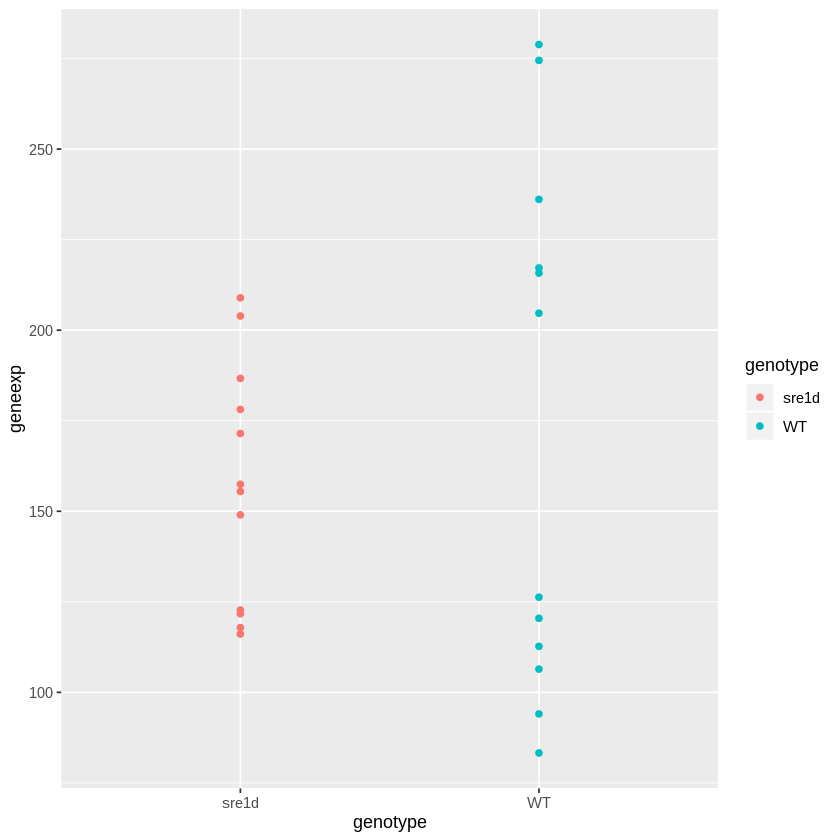

In [15]:
### Stratify by genotype
myDEplot0(ddsadd, "CNAG_00003", "genotype", "Label")

## Volcano plots

Warning message:
“Removed 348 rows containing missing values (geom_point).”

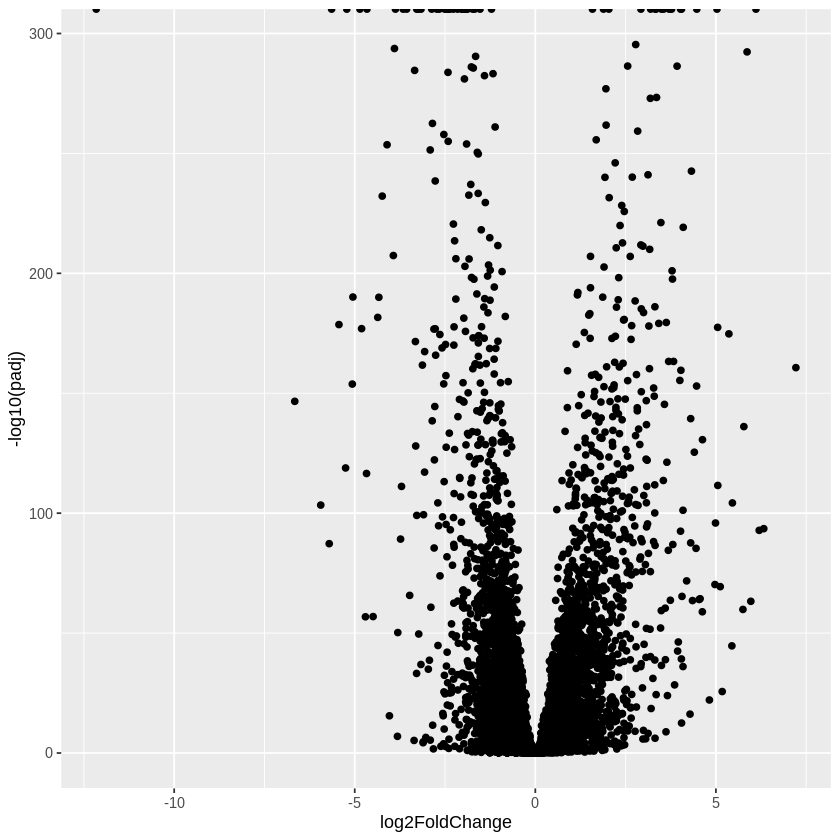

In [17]:
### Volcano plot for condition effect
ggplot(results(ddsadd, contrast = c("condition", "pH4", "pH8"), tidy = TRUE), 
       aes(x = log2FoldChange, y = -log10(padj))) + geom_point()

## 

Warning message:
“Removed 348 rows containing missing values (geom_point).”

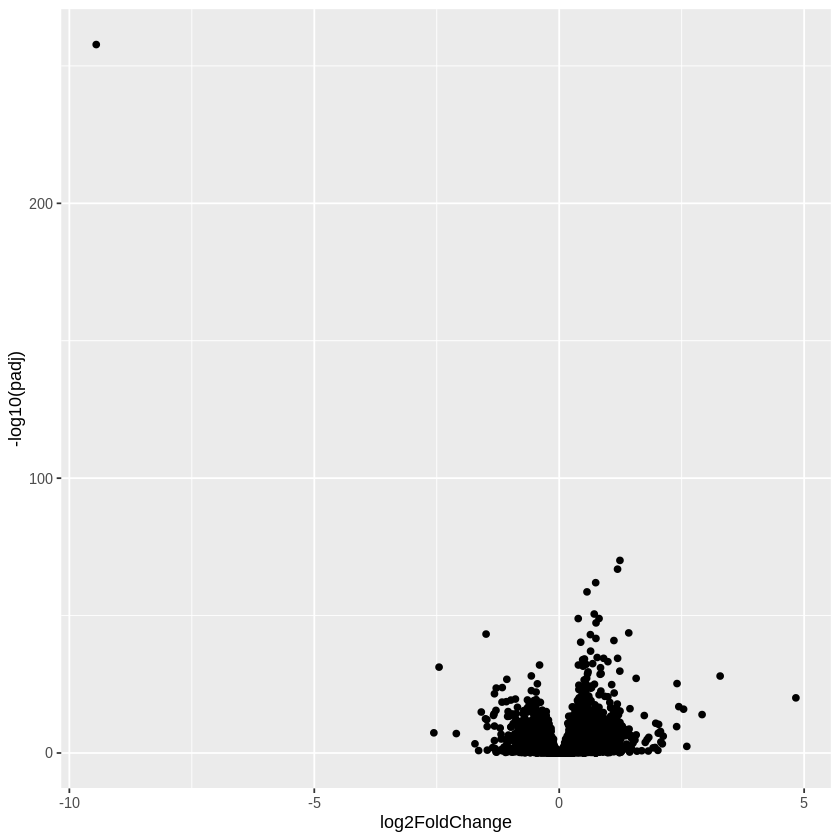

In [18]:
### Volcano plot for genotype effect
ggplot(results(ddsadd, contrast = c("genotype", "sre1d", "WT"), tidy = TRUE), 
       aes(x = log2FoldChange, y = -log10(padj))) + geom_point()

## Get "expression" data from counts

In [37]:
### Normalized counts
normexp <- assay(ddsadd, normalize=TRUE)
class(normexp)

[1] "matrix"

In [46]:
### rlog transform
rlexp <- rlog(ddsadd, blind = TRUE)
class(rlexp)

[1] "DESeqTransform"
attr(,"package")
[1] "DESeq2"

In [50]:
vstexp <- vst(ddsadd)
class(vstexp)

[1] "DESeqTransform"
attr(,"package")
[1] "DESeq2"

In [41]:
### FPM
fpmexp <- fpm(ddsadd)
class(normexp)

[1] "matrix"

## Principal Components Analysis

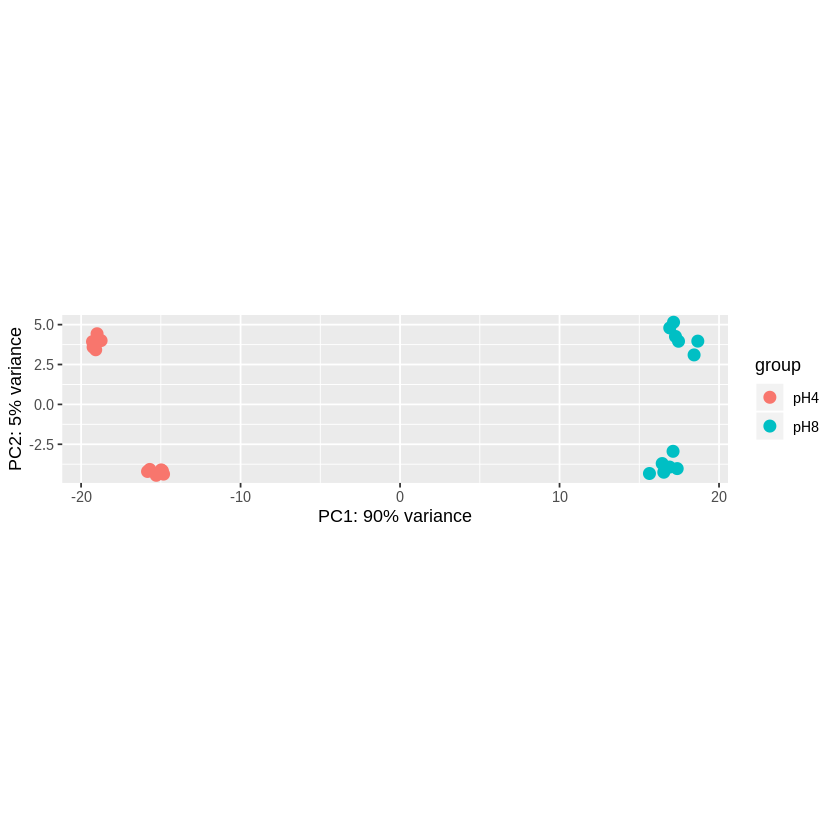

In [42]:
###  Color by condition
plotPCA(rlexp, intgroup = c("condition"))

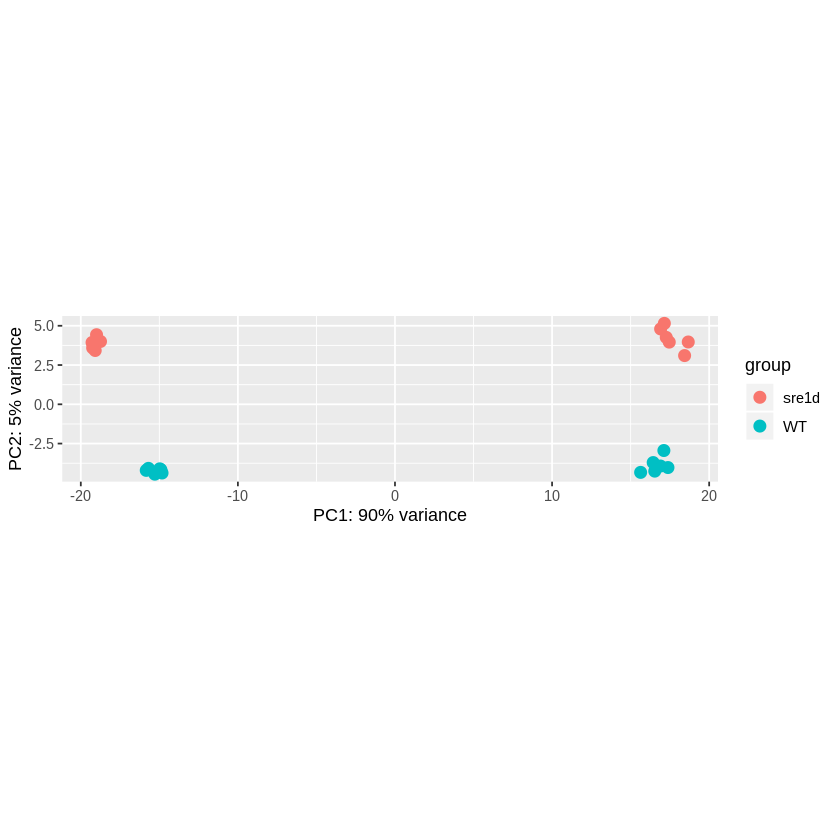

In [43]:
###  Color by genotype
plotPCA(rlexp, intgroup = c("genotype"))

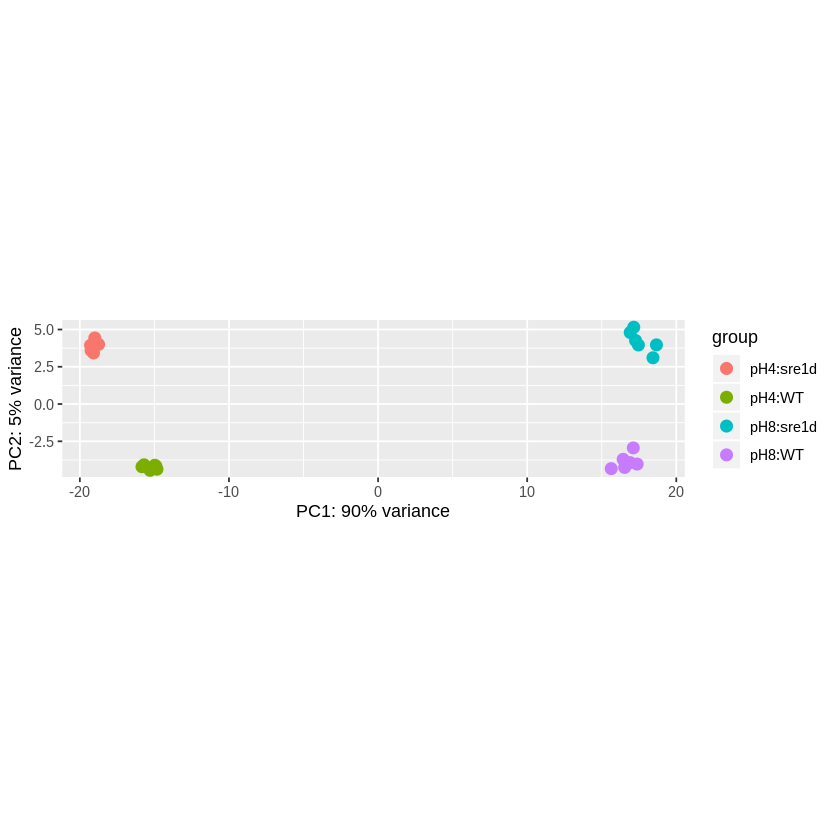

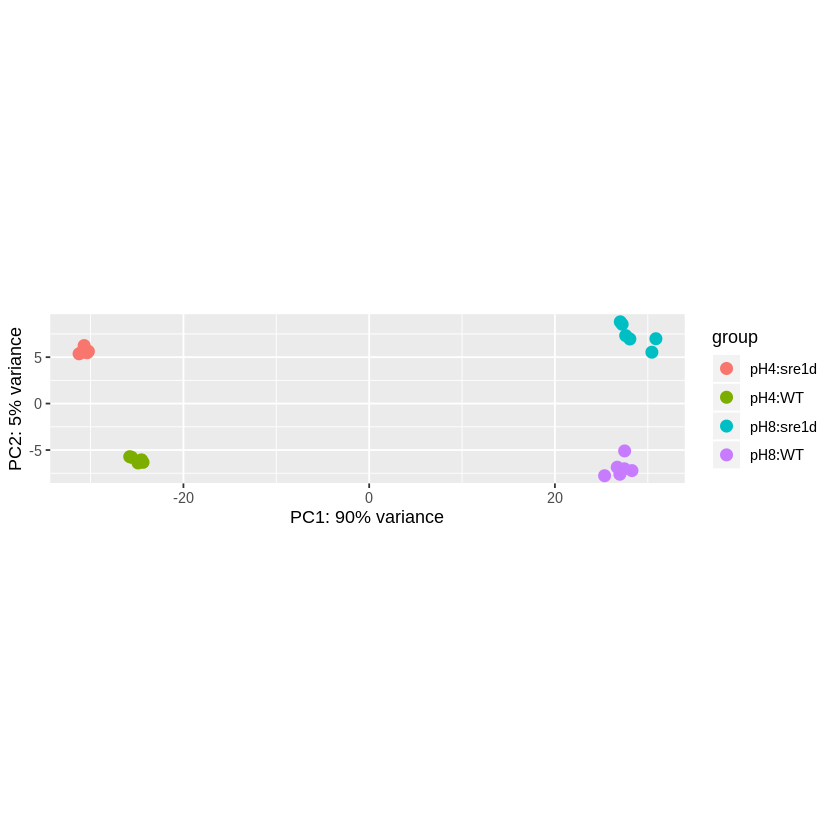

In [57]:
### Color by condition and genotype using rlog and then vst transformed counts
plotPCA(rlexp, intgroup = c("condition", "genotype"))
plotPCA(vstexp, intgroup = c("condition", "genotype"))

## Clustering

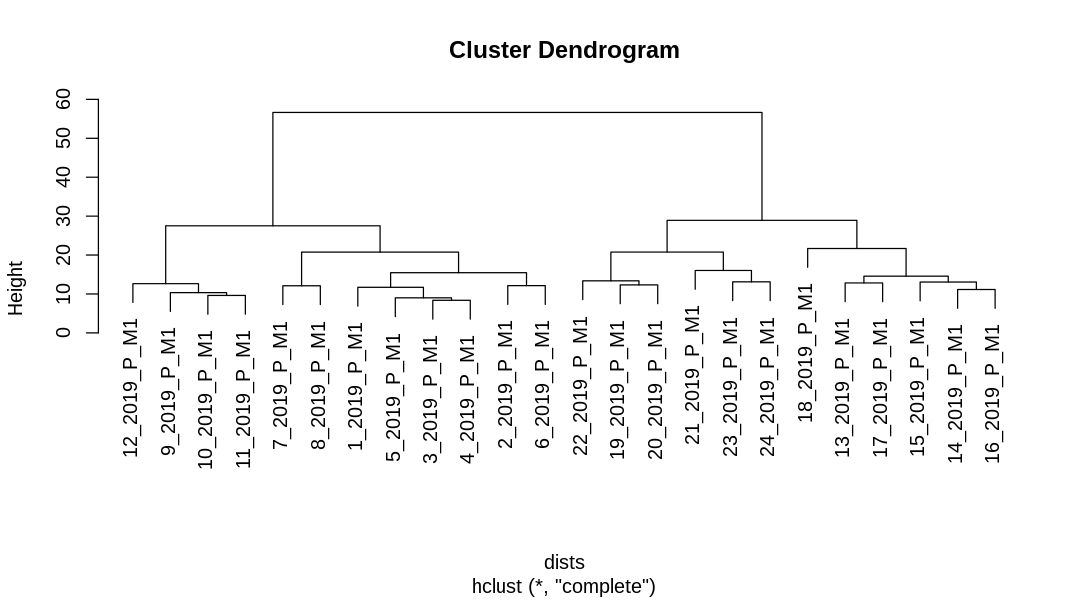

In [59]:
### Simple dendogram with no annotation
options(repr.plot.width = 9, repr.plot.height = 5)
dists <- dist(t(assay(rlexp)))
plot(hclust(dists, metho = "complete")) 

In [60]:
### Create dendogram object
assay(rlexp) %>%
    t() %>%
        dist %>%
            hclust(method = "complete") %>%
                as.dendrogram -> mydend

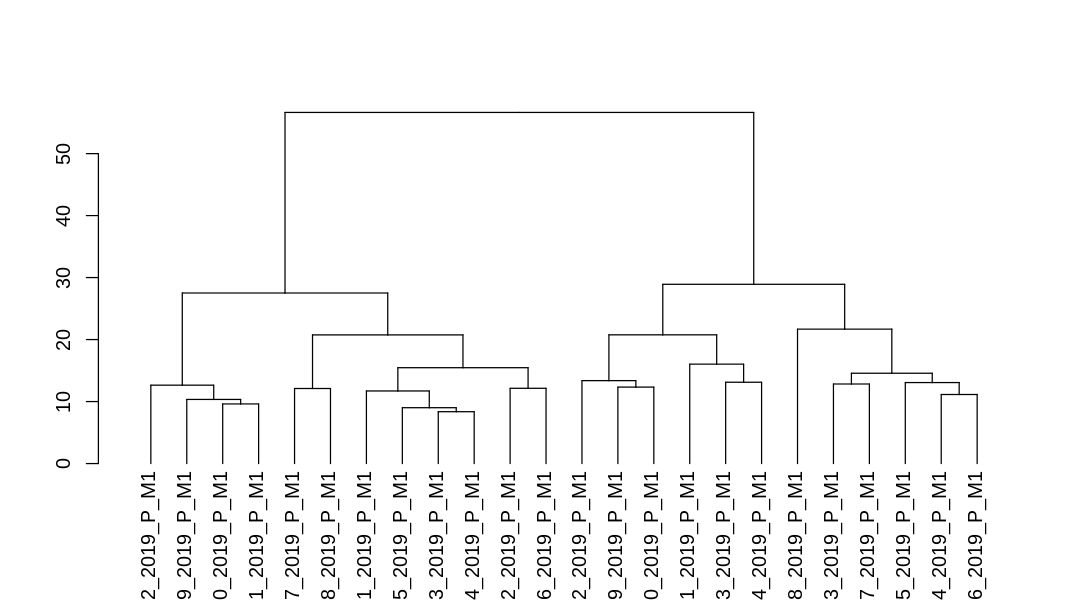

In [61]:
### Plot dendogram object
plot(mydend)

In [62]:
### Function to annotate dendogram object
dendplot <- function(mydend, columndata, labvar, colvar, pchvar) {
    cols <- factor(columndata[[colvar]][order.dendrogram(mydend)])
    collab <- brewer.pal(max(3,nlevels(cols)),"Set1")[cols]
    pchs <- factor(columndata[[pchvar]][order.dendrogram(mydend)])
    pchlab <- seq_len(nlevels(pchs))[pchs]
    lablab <- columndata[[labvar]][order.dendrogram(mydend)]
    
    mydend %>% 
        set("labels_cex",1) %>% 
        set("labels_col",collab) %>%
        set("leaves_pch",pchlab) %>%
        set("labels", lablab)
}

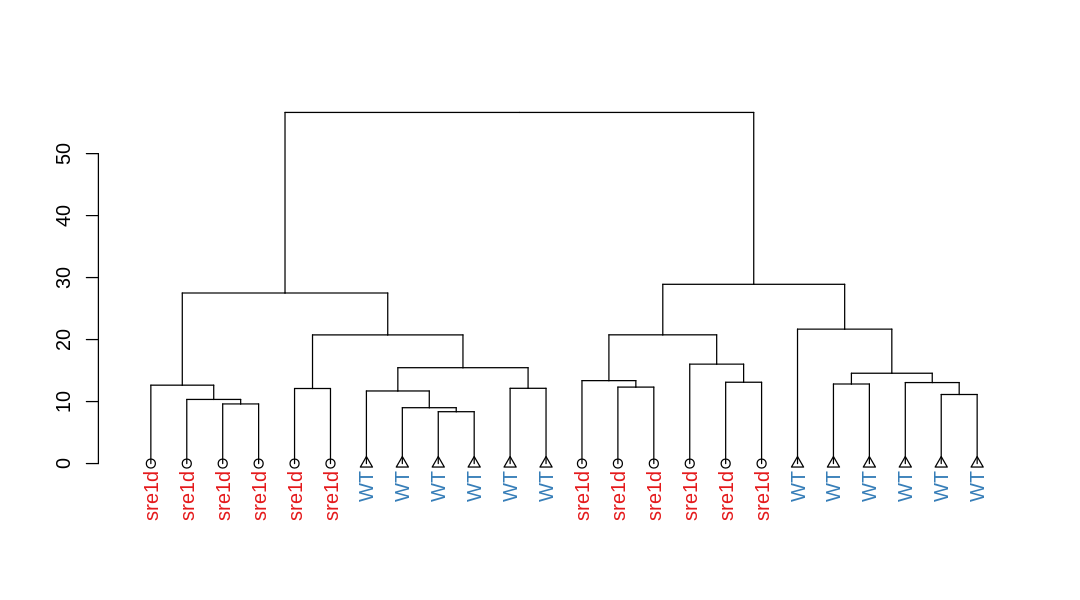

In [65]:
### Annotate genotype only
dendplot(mydend, ddsadd@colData, 
         "genotype",    # variable that show in label
         "genotype",    # variable that define color
         "genotype") %>% # variable that define shape of points
    plot

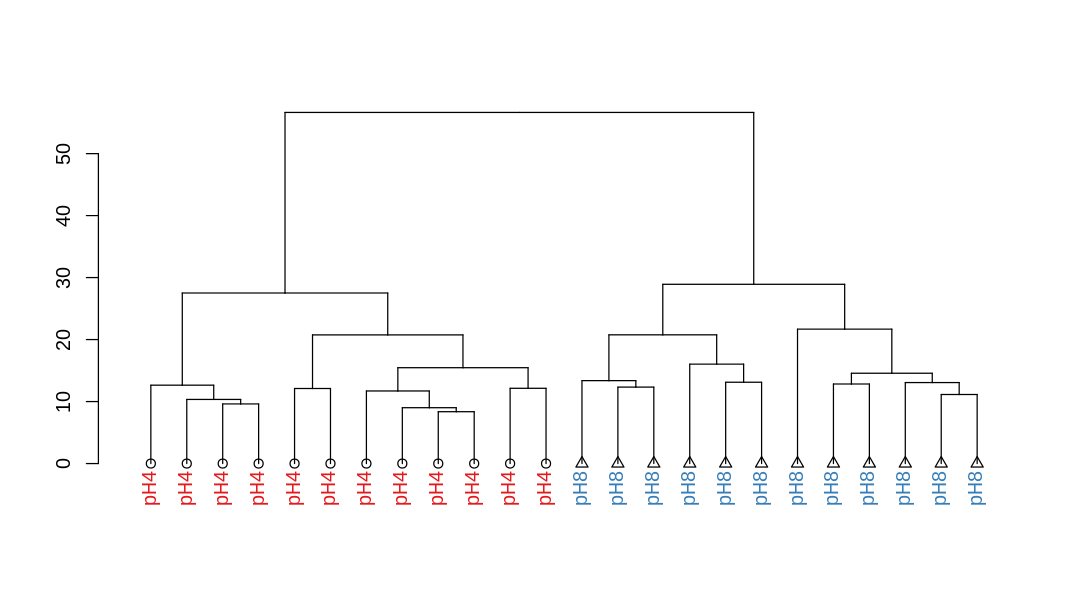

In [66]:
### Annotate condition only
dendplot(mydend, ddsadd@colData, 
         "condition",    # variable that show in label
         "condition",    # variable that define color
         "condition") %>% # variable that define shape of points
    plot

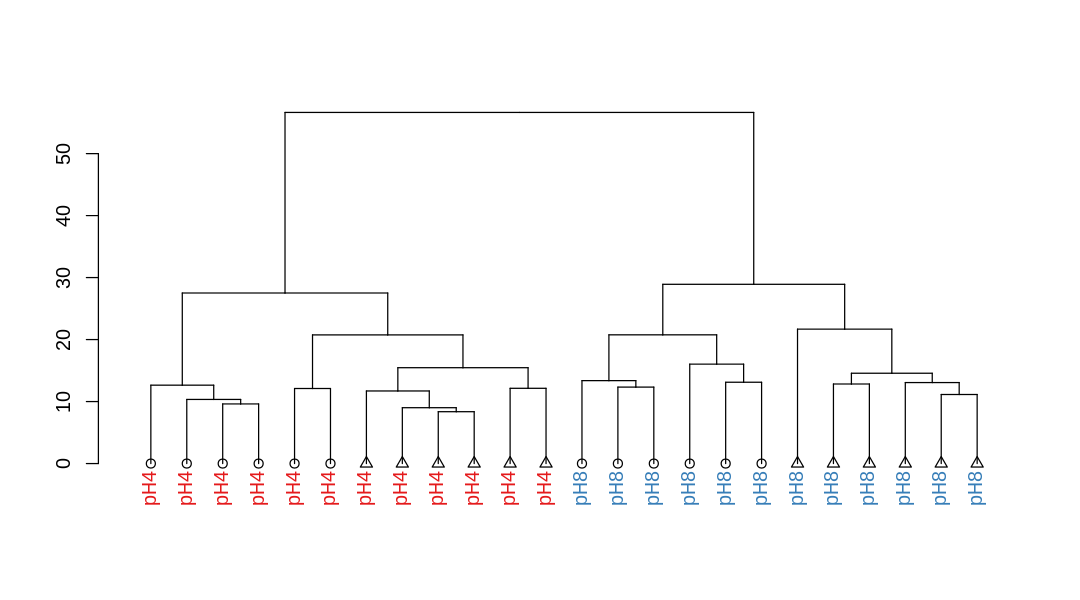

In [67]:
### Annotate condition and genotype
dendplot(mydend, ddsadd@colData, 
         "condition",    # variable that show in label
         "condition",    # variable that define color
         "genotype") %>% # variable that define shape of points
    plot

In [ ]:
sessionInfo()